# Image Classification using CNN in Pytorch

## (a) Dataloader     and     (c) Data Split

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, x_file, y_file=None, transform=None):
        self.x = np.load(x_file)
        self.y = np.load(y_file)
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        sample = self.x[idx].reshape(28, 28)  # Reshape to 28x28
        label = self.y[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label


# Define data loader
def create_data_loader(x_train_file, y_train_file, batch_size, validation_split):
    # Load training data
    dataset = CustomDataset(x_train_file, y_train_file)
    dataset_size = len(dataset)
    split = int(np.floor(validation_split * dataset_size))
    indices = list(range(dataset_size))
    np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    valid_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    validation_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

    # Load test data
    #test_dataset = CustomDataset(x_test_file, None)
    #test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, validation_loader


x_train_file = 'x_train.npy'
y_train_file = 'y_train.npy'
x_test_file = 'x_test.npy'

train_loader, validation_loader = create_data_loader(x_train_file, y_train_file, batch_size=64, validation_split=0.2)


## (b) Data Exploration

Samples per digit: {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


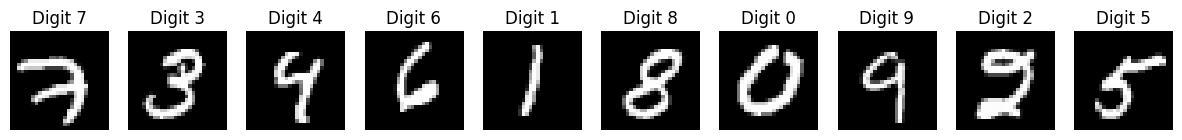

In [3]:
import matplotlib.pyplot as plt

# Function to visualize one example from each digit
def visualize_samples(dataset):
    digit_samples = {}
    for i in range(len(dataset)):
        image, label = dataset[i]
        if label not in digit_samples:
            digit_samples[label] = image
        if len(digit_samples) == 10:
            break

    fig, axs = plt.subplots(1, 10, figsize=(15, 5))
    for i, (label, image) in enumerate(digit_samples.items()):
        axs[i].imshow(image, cmap='gray')
        axs[i].set_title(f'Digit {label}')
        axs[i].axis('off')
    plt.show()

# Count number of samples per digit
def count_samples_per_digit(y_file):
    if y_file is not None:
        y = np.load(y_file)
        unique, counts = np.unique(y, return_counts=True)
        samples_per_digit = dict(zip(unique, counts))
    else:
        samples_per_digit = None
    return samples_per_digit


samples_per_digit = count_samples_per_digit('y_train.npy')
print("Samples per digit:", samples_per_digit)
visualize_samples(CustomDataset('x_train.npy', 'y_train.npy', transform=None))


<p> The Data Distribution is not balanced.</p>

## (d) Modeling

In [4]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# Define CNN model with configurable hyperparameters
class CNN(nn.Module):
    def __init__(self, filter_size=3, num_filters=32, activation='relu'):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, num_filters, kernel_size=filter_size)
        self.conv2 = nn.Conv2d(num_filters, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'tanh':
            self.activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(F.max_pool2d(self.conv1(x), 2))
        x = self.activation(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 64 * 5 * 5)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

# Function to train the model
def train_model(model, train_loader, validation_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs.unsqueeze(1).float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Print loss after every epoch
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

        # Validate the model
        validate_model(model, validation_loader)

# Function to validate the model
def validate_model(model, validation_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validation_loader:
            inputs, labels = data
            outputs = model(inputs.unsqueeze(1).float())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on validation set: {accuracy:.2f}%')
    return total, accuracy  # Return total samples and accuracy

# Hyperparameters to experiment with
filter_sizes = [3, 5]
num_filters_list = [32, 64]
activation_functions = ['relu', 'sigmoid', 'tanh']

best_accuracy = 0
best_model = None
best_hyperparameters = {}

# Iterate over all combinations of hyperparameters
for filter_size in filter_sizes:
    for num_filters in num_filters_list:
        for activation in activation_functions:
            print(f'\nExperimenting with filter_size={filter_size}, num_filters={num_filters}, activation={activation}')
            model = CNN(filter_size=filter_size, num_filters=num_filters, activation=activation)
            train_model(model, train_loader, validation_loader)
            # Get accuracy on validation set
            _, accuracy = validate_model(model, validation_loader)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = model
                best_hyperparameters = {'filter_size': filter_size, 'num_filters': num_filters, 'activation': activation}

print(f'\nBest hyperparameters: {best_hyperparameters}')
print(f'Best accuracy on validation set: {best_accuracy:.2f}%')



Experimenting with filter_size=3, num_filters=32, activation=relu


/scratch/user/apurva.mandalika/ML4/HW/lib/python3.8/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Loss: 0.21479703843221068
Accuracy on validation set: 98.04%
Epoch 2, Loss: 0.061846952700056135
Accuracy on validation set: 98.68%
Epoch 3, Loss: 0.04211553451186046
Accuracy on validation set: 98.59%
Epoch 4, Loss: 0.031600404852457964
Accuracy on validation set: 98.72%
Epoch 5, Loss: 0.02497343799987963
Accuracy on validation set: 99.01%
Epoch 6, Loss: 0.018849722537212073
Accuracy on validation set: 99.16%
Epoch 7, Loss: 0.015165033011464402
Accuracy on validation set: 98.92%
Epoch 8, Loss: 0.011942977800126148
Accuracy on validation set: 98.80%
Epoch 9, Loss: 0.011303338249204292
Accuracy on validation set: 99.11%
Epoch 10, Loss: 0.009010266820724307
Accuracy on validation set: 99.04%
Accuracy on validation set: 99.04%

Experimenting with filter_size=3, num_filters=32, activation=sigmoid
Epoch 1, Loss: 0.9961631206373374
Accuracy on validation set: 91.57%
Epoch 2, Loss: 0.19705882706741493
Accuracy on validation set: 96.13%
Epoch 3, Loss: 0.11391885791222255
Accuracy on v

## (g) Inference

In [9]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
# Load the test data
x_test = np.load('x_test.npy')

# Convert the test data into a PyTorch TensorDataset
test_dataset2 = TensorDataset(torch.from_numpy(x_test))

# Define a DataLoader for the test dataset
test_loader2 = DataLoader(test_dataset2, batch_size=64)

In [10]:
import numpy as np

def inference_test(model, test_loader):
    predictions = []
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for data in test_loader:
            inputs = data[0].unsqueeze(1).float()  # Reshape the input data
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
    return predictions

# Perform inference on test dataset using the best model
predictions = inference_test(best_model, test_loader2)

# Save predictions to CSV file
def save_predictions_to_csv(predictions, filename):
    np.savetxt(filename, predictions, delimiter=",", fmt='%d')

save_predictions_to_csv(predictions, 'Apurva_Mandalika_Preds.csv')


## Bonus : Filter Visualization

/work/job.14531673/ipykernel_12375/726368083.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)  # Convert input data to float32


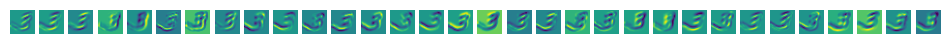

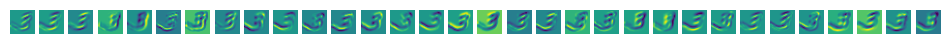

In [11]:
import torch
import matplotlib.pyplot as plt

def visualize_feature_maps6(model, image):
    activations = []  # To store intermediate feature maps

    # Register hooks to extract feature maps after the first and last convolution layers
    def hook_fn(module, input, output):
        activations.append(output.squeeze(0))

    # Register hook for the first convolutional layer
    model.conv1.register_forward_hook(hook_fn)
    
    # Forward pass the image through the model
    model.eval()
    with torch.no_grad():
        model(image.unsqueeze(0)) 

    # Visualize feature maps after the first convolutional layer
    plt.figure(figsize=(12, 6))
    num_feature_maps = activations[0].shape[0]
    
    for i in range(num_feature_maps):
        plt.subplot(1, num_feature_maps, i + 1)
        plt.imshow(activations[0][i].detach().cpu(), cmap='viridis')
        #plt.title(f'Feature Map {i+1} after First Convolutional Layer')
        plt.axis('off')
    
    plt.show()

    activations = []  # Reset activations

    # Register hook for the last convolutional layer
    model.conv2.register_forward_hook(hook_fn)
    
    # Forward pass again
    with torch.no_grad():
        model(image.unsqueeze(0))

    # Visualize feature maps after the last convolutional layer
    plt.figure(figsize=(12, 6))
    num_feature_maps = activations[0].shape[0]
    for i in range(num_feature_maps):
        plt.subplot(1, num_feature_maps, i + 1)
        plt.imshow(activations[0][i].detach().cpu(), cmap='viridis')
        plt.axis('off')
        #plt.title(f'Feature Map {i+1} after Last Convolutional Layer')
    plt.show()


for batch in train_loader:
    random_index = np.random.randint(len(batch[0]))  # Randomly select an index within the batch
    random_image = batch[0][random_index]  # Get the randomly chosen image from the batch
    break  # Exit the loop after the first batch to get only one random image

image = random_image.clone().detach()  # Clone and detach the tensor
image = torch.tensor(image, dtype=torch.float32)  # Convert input data to float32

# Now passing the converted image to visualize_feature_maps function
visualize_feature_maps6(best_model, image)
